# MAGAN 
## Manifold alignment generative adversarial network

In this exercise we will reproduce the following GAN architecture:

<img src="magan_arch.png" width=600 height=400 />

See the [Original paper](http://proceedings.mlr.press/v80/amodio18a/amodio18a.pdf)



In [1]:
import numpy as np
import torchvision
from torchvision import transforms
import pandas as pd
import sklearn
import torch
from PIL import Image, ImageFilter 

import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset
import seaborn as sns
import pandas as pd


In [2]:
'''
*** Explain ***
What does the following class do, and why we need to do this? 
'''

class mnist_double():
    def __init__(self, gausBl = 1, Rota = 30, resh_size = 14):
        
        ''' Import MNIST
        '''
        # If you don't download, specify the repo using the following line
        # data_path = r"...your repo for the data" 
        Mnist = torchvision.datasets.MNIST(root = './data', 
                                           transform = torchvision.transforms.ToTensor(),
                                           download = True)
        
        data = Mnist.data.reshape(60000,784)
        train_X = data
        train_X = train_X/train_X.max()
        true_labels = Mnist.targets
        
        indc = np.random.choice(range(data.shape[0]), 2000, replace = False)

        X = train_X[indc,:]
        true_labels = true_labels[indc]
        
        images_transform = torch.zeros(X.shape[0], 28, 28)
        for ind in range(len(X)):
            transform = transforms.ToPILImage()
            pilimg = transform(X[ind].reshape(28,28))
            im2 = pilimg.filter(ImageFilter.GaussianBlur(radius = gausBl))
            im2 = im2.rotate(Rota)
            transform = transforms.ToTensor()
            images_transform[ind] = transform(im2).squeeze()
        
        images_transform = images_transform.reshape(X.shape[0], 28 * 28)
           
        
        if resh_size < 28:
            images_transform_gb = images_transform.clone()
            images_transform = torch.zeros(X.shape[0], resh_size, resh_size)        
            p = transforms.Resize((resh_size, resh_size))
            transform = transforms.ToPILImage()
            transform_t = transforms.ToTensor()
            for ind in range(len(X)):
                images_transform[ind] = transform_t(p(transform(images_transform_gb[ind].reshape(28,28)))).squeeze()
            images_transform = images_transform.reshape(X.shape[0], resh_size * resh_size) 
            
        ins = np.argsort(true_labels)
        self.domain1 = X[ins]
        self.domain2 = images_transform[ins]
        self.type1 = true_labels[ins]
        self.type2 = true_labels[ins]
        self.correspondence = True
    def get_data(self):
        return self.domain1, self.domain2,  self.type1, self.type2  
    def get_embeddings(self):
        return self.domain1[:,:2], self.domain2[:,:2]

In [3]:
domain1, domain2, labels1, labels2 = mnist_double(gausBl = 1).get_data()

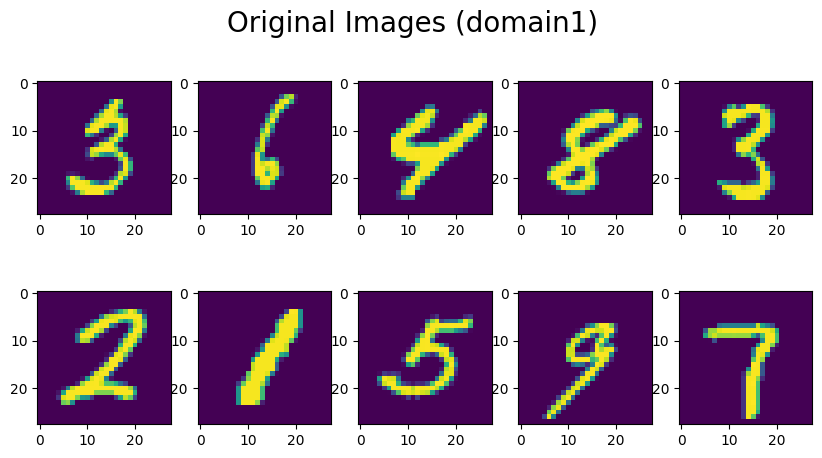

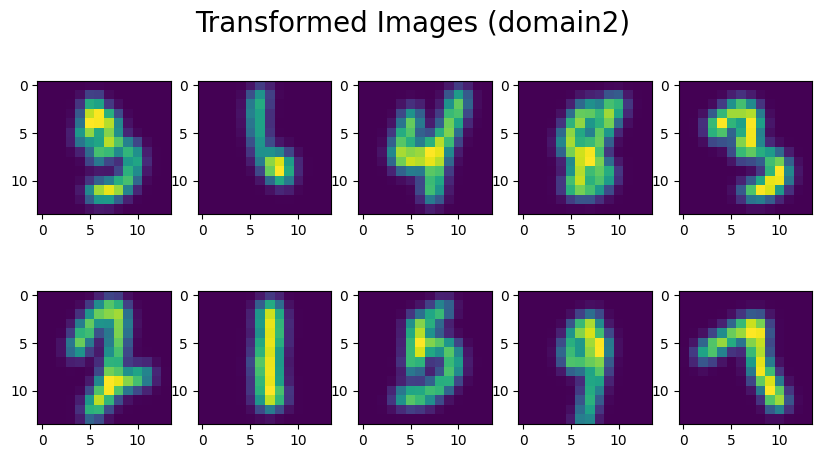

In [4]:
indices_plot = np.random.choice(range(domain1.shape[0]), 10, replace = False)

fig, ax = plt.subplots(2, 5, figsize = (10, 5))  
ax = ax.flatten()
for i in range(len(indices_plot)):
    ax[i].imshow(domain1[indices_plot[i]].reshape(28,28))
fig.suptitle("Original Images (domain1)", size=20)
plt.show()


fig, ax = plt.subplots(2, 5, figsize = (10, 5))  
ax = ax.flatten()
for i in range(len(indices_plot)):
    ax[i].imshow(domain2[indices_plot[i]].reshape(14, 14))
fig.suptitle("Transformed Images (domain2)", size=20)
plt.show()


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import pdb
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np

'''
*** Explain ***
Looking at the following class, explain what is a generator?
'''

class MAGAN_generator(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        # pdb.set_trace()
                
        full_list = list(hidden_dims) 
        # Create generator 
        self.generator = nn.Sequential()
        self.generator.add_module(f'gen_ini', nn.Linear(input_dim, full_list[0]))
        # self.generator.add_module(f'batchn_', nn.BatchNorm1d(full_list[0]))
        self.generator.add_module(f'act_',nn.LeakyReLU(negative_slope=0.2))
        for i in range(len(full_list)-1):
            self.generator.add_module(f'gen_{i}' ,nn.Linear(full_list[i], full_list[i+1]))
            # self.generator.add_module(f'batchn_{i}', nn.BatchNorm1d(full_list[i+1]))
            self.generator.add_module(f'act_{i}',nn.LeakyReLU(negative_slope=0.2))
        
        self.generator.add_module(f'final_gen', nn.Linear(full_list[i+1], output_dim))
        self.generator.add_module('final_act', nn.Sigmoid())
        
    def forward(self, x1):
        out = self.generator(x1)
        return out

'''
*** Explain ***
Looking at the following class,explain what is a discriminator? 
Why the dimension of the output of the final layer is equal to 1? 
'''

class MAGAN_discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        # pdb.set_trace()

        full_list = list(hidden_dims) 
        
        # Create discriminator 
        self.discriminator = nn.Sequential()
        self.discriminator.add_module('gen_ini', nn.Linear(input_dim, full_list[0]))
        # self.discriminator.add_module('batchn_ini', nn.BatchNorm1d(full_list[0]))
        self.discriminator.add_module('act_ini',nn.LeakyReLU(negative_slope=0.2))
        for i in range(len(full_list)-1):
            self.discriminator.add_module(f'gen_{i}' ,nn.Linear(full_list[i], full_list[i+1]))
            # self.discriminator.add_module(f'batchn_{i}', nn.BatchNorm1d(full_list[i+1]))
            self.discriminator.add_module(f'act_{i}',nn.LeakyReLU(negative_slope=0.2))
        
        self.discriminator.add_module('final_gen', nn.Linear(full_list[i+1], 1))
        # self.discriminator.add_module('final_act', nn.Sigmoid())
        
    def forward(self, x1):
        out = self.discriminator(x1)
        return out    

class MAGAN_dis(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dims):
        super().__init__()     
        
        '''
        *** Explain *** what are D1 and D2?
        '''
                                                                                                
        self.D1 = MAGAN_discriminator(input_dim1, hidden_dims)
        self.D2 = MAGAN_discriminator(input_dim2, hidden_dims)
        
    def forward(self, X1, X2, X21, X12):

        Dx1 = self.D1(X1)
        Dx21 = self.D1(X21)
        Dx2 = self.D2(X2)
        Dx12 = self.D2(X12) 
        return Dx1, Dx21, Dx2, Dx12


class MAGAN_gen(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dims):
        super().__init__()     
        
        '''
        *** Explain *** what are G12 and G21?
        '''
        
        self.G12 = MAGAN_generator(input_dim1, hidden_dims, input_dim2)
        self.G21 = MAGAN_generator(input_dim2, hidden_dims, input_dim1)

    def forward(self, X1, X2, s1, s2):
        '''
        *** Explain ***
        What does this function forward() do?
        '''
        
        X12 = self.G12(X1)
        X121 = self.G21(X12)
        
        X21 = self.G21(X2)
        X212 = self.G12(X21)
        
        S12 = self.G12(s1)
        S21 = self.G21(s2)
        
        return X12, X121, X21, X212, S12, S21 

                                                                                
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)



class MAGAN():
    def __init__(self, lam = 1000, 
                 epochs=100, 
                 hidden_dims = [400, 200, 100],
                 torch_module = None,
                 optimizer = None,
                 lr = 1e-3,
                 batch_size = 128,
                 weight_decay = 0):
        
        self.torch_module = torch_module
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.hidden_dims = hidden_dims
        self.lr = lr
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.epochs = epochs
        self.dis_loss = nn.BCELoss(reduction = 'mean')
        self.dis_loss = nn.BCEWithLogitsLoss()
        self.gen_loss = nn.MSELoss(reduction = 'mean')
        self.lam =  lam
        
    def fit(self, X1, X2, s1 = None, s2 = None):
        
        input_dim1 = X1.shape[1]
        input_dim2 = X2.shape[1]
        if self.torch_module is None:
            self.torch_module_gen = MAGAN_gen(input_dim1 = input_dim1,
                                              input_dim2 = input_dim2,
                                              hidden_dims = self.hidden_dims)
            self.torch_module_dis = MAGAN_dis(input_dim1 = input_dim1,
                                              input_dim2 = input_dim2,
                                              hidden_dims = self.hidden_dims)
            # self.torch_module_gen.apply(weights_init_uniform)
            # self.torch_module_dis.apply(weights_init_uniform)
        
        if self.optimizer is None:
            self.optimizer_gen = torch.optim.Adam(self.torch_module_gen.parameters(),
                                              lr=self.lr,
                                              weight_decay=self.weight_decay)
            self.optimizer_dis = torch.optim.Adam(self.torch_module_dis.parameters(),
                                                  lr=self.lr,
                                                  weight_decay=self.weight_decay)
            
            
        self.X1 = torch.tensor(X1).float() 
        self.X2 = torch.tensor(X2).float() 
        s1 = torch.tensor(s1).float().to(self.device)
        s2 = torch.tensor(s2).float().to(self.device) 
        self.torch_module_gen.to(self.device)
        self.torch_module_dis.to(self.device)
        self.loader = self.get_loader(self.X1, self.X2)
        self.noiseb = 0
        self.d1_l = [0]
        self.d2_l = [0]
        self.g1_l = [0]
        self.g2_l = [0]
        self.train_g = True
        
        for epoch in range(self.epochs):
            if epoch % 50 == 1:
                print(f'Epoch {epoch} of self.epochs')
                print(f"{self.loss}")
                plt.plot(self.d1_l + self.d2_l, c = "blue")
                # plt.plot(self.d2_l, c = "green")
                plt.plot(self.g2_l + self.g1_l, c = "black")
                # plt.plot(self.g1_l, c = "red")
                plt.show()
                self.noiseb = np.clip(self.noiseb * 0.5, 0, 1)
            
            if epoch > 10:
                if self.d1_l[-1] + self.d2_l[-1] > 1:
                    self.train_g = True
                else:
                    self.train_g = True
            for batch in self.loader:
                                          
                X1, X2 = batch
                X1 = X1.to(self.device)
                X2 = X2.to(self.device)
                # discriminator loss
                self.train_generators(X1, X2, s1, s2, self.train_g)
                self.train_discriminators(X1, X2, s1, s2) 
                self.loss = self.g1_l[-1] + self.g2_l[-1] + self.d1_l[-1] + self.d2_l[-1]
                

        
        X12, X121, X21, X212, S12, S21 = self.torch_module_gen(self.X1.to(self.device), self.X2.to(self.device), s1, s2)
        nbrs = NearestNeighbors(n_neighbors=X12.shape[0], algorithm='ball_tree').fit(X12.detach().cpu())
        _, indices = nbrs.kneighbors(self.X2)
        a2 = indices[:,0]
        
        N1 = self.X1.shape[0]
        N2 = self.X2.shape[0]
        T = np.zeros((N1, N2))
        T[range(N1), a2] = 1  
        
        return T
    
    def train_discriminators(self, X1, X2, s1, s2):
        self.optimizer_dis.zero_grad()
        X12, X121, X21, X212, S12, S21 = self.torch_module_gen(X1, X2, s1, s2)
        Dx1, Dx21, Dx2, Dx12 = self.torch_module_dis(X1, X2, X21, X12)
        
        '''
        *** Explain ***
        What does this function train_discriminators() do?
        '''
        
        lossD1 = self.dis_loss(Dx1, torch.bernoulli(torch.ones_like(Dx1)*(1-self.noiseb)))
        lossD2 = self.dis_loss(Dx2, torch.bernoulli(torch.ones_like(Dx2)*(1-self.noiseb)))
        lossD1_f = self.dis_loss(Dx12, torch.bernoulli(torch.ones_like(Dx1)*self.noiseb))
        lossD2_f = self.dis_loss(Dx21, torch.bernoulli(torch.ones_like(Dx1)*self.noiseb))
                                
        # lossD1 = self.dis_loss(Dx1, torch.ones_like(Dx1))
        # lossD2 = self.dis_loss(Dx2, torch.ones_like(Dx2))
        
        # lossD1_f = self.dis_loss(Dx12, torch.zeros_like(Dx12))
        # lossD2_f = self.dis_loss(Dx21, torch.zeros_like(Dx21))         
        # lossD1 = F.binary_cross_entropy_with_logits(Dx1, torch.ones_like(Dx1))
        # lossD2 = F.binary_cross_entropy_with_logits(Dx2, torch.ones_like(Dx2))       
        # lossD1_f = F.binary_cross_entropy_with_logits(Dx12, torch.zeros_like(Dx12))
        # lossD2_f = F.binary_cross_entropy_with_logits(Dx21, torch.zeros_like(Dx21))  
        LossD =  lossD1 + lossD2 + lossD1_f + lossD2_f
        LossD.backward()             
        self.d1_l.append(lossD1.item() + lossD1_f.item())
        self.d2_l.append(lossD2.item() + lossD2_f.item())
        self.optimizer_dis.step()
        
    def train_generators(self, X1, X2, s1, s2, train):
        self.optimizer_gen.zero_grad()
        X12, X121, X21, X212, S12, S21 = self.torch_module_gen(X1, X2, s1, s2)
        Dx1, Dx21, Dx2, Dx12 = self.torch_module_dis(X1, X2, X21, X12)
        
                
        '''
        *** Explain ***
        What does this function train_generators() do?
        '''
        
        lossG12 = self.dis_loss(Dx12, torch.ones_like(Dx12))
        lossG21 = self.dis_loss(Dx21, torch.ones_like(Dx21))
        
        lossG12_r = self.gen_loss(X1, X121)
        lossG21_r = self.gen_loss(X2, X212)
        
        self.g1_l.append(lossG12.item() + lossG12_r.item())
        self.g2_l.append(lossG21.item() + lossG21_r.item())
        # Correspondence Loss
        C12 = self.gen_loss(s2, S12)
        C21 = self.gen_loss(s1, S21)
        
        LossG =  lossG12 + lossG21 + lossG12_r + lossG21_r + self.lam*(C12 + C21)
        LossG.backward()  
        if train:
            self.optimizer_gen.step()
                       
    
    def get_loader(self, X1, X2):
        loader1 = torch.utils.data.DataLoader(ConcatDataset(X1, X2), batch_size=self.batch_size, shuffle=False) 
        return  loader1  
    
    def transform(self, x1, x2):
        X12, X121, X21, X212, s1, s2 = self.torch_module_gen(x1.to(self.device), x2.to(self.device), x1.to(self.device), x2.to(self.device))
        return X12.detach().cpu().numpy(), X21.detach().cpu().numpy()

    



In [6]:
# Create random correspondences between both domains
indices_correspondence = np.random.choice(range(domain1.shape[0]), 100, replace = False)

In [7]:
model = MAGAN()

Epoch 1 of self.epochs
7.573154157958925


/tmp/ipykernel_13289/954665261.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X1 = torch.tensor(X1).float()
/tmp/ipykernel_13289/954665261.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X2 = torch.tensor(X2).float()
/tmp/ipykernel_13289/954665261.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s1 = torch.tensor(s1).float().to(self.device)
/tmp/ipykernel_13289/954665261.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().

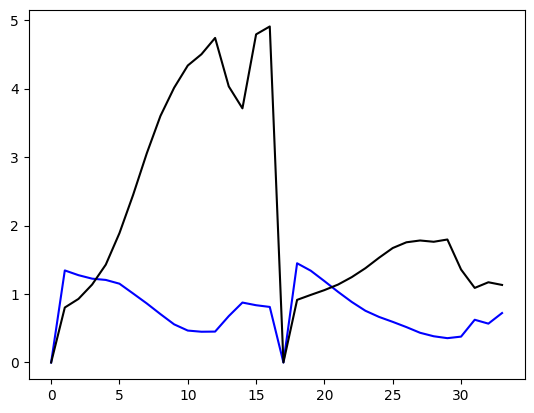

Epoch 51 of self.epochs
3.9057231564074755


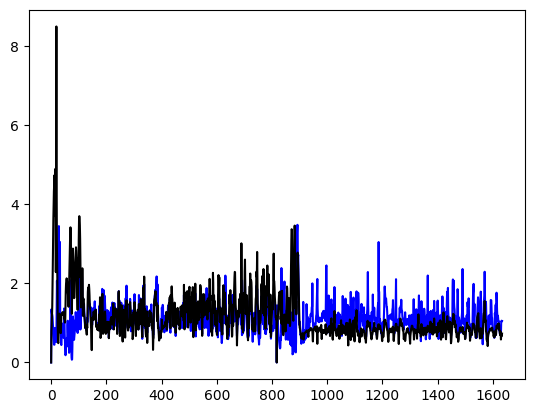

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [12]:
model.fit(domain1, domain2, domain1[indices_correspondence], domain2[indices_correspondence])

In [13]:
x2g, x1g = model.transform(domain1, domain2)

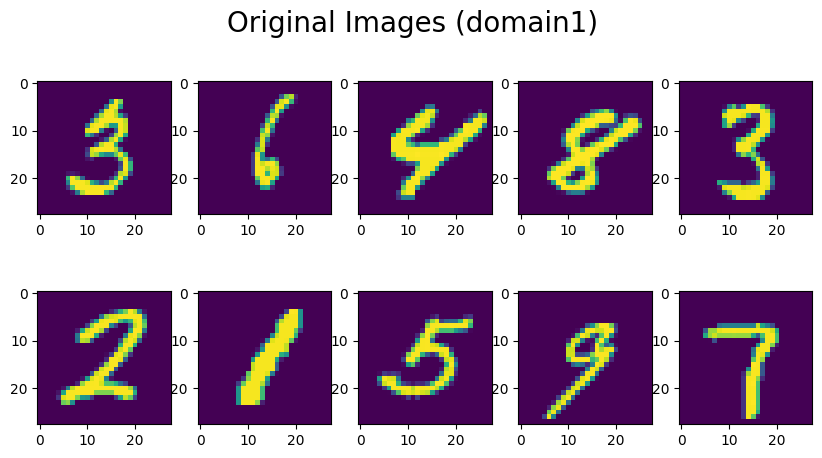

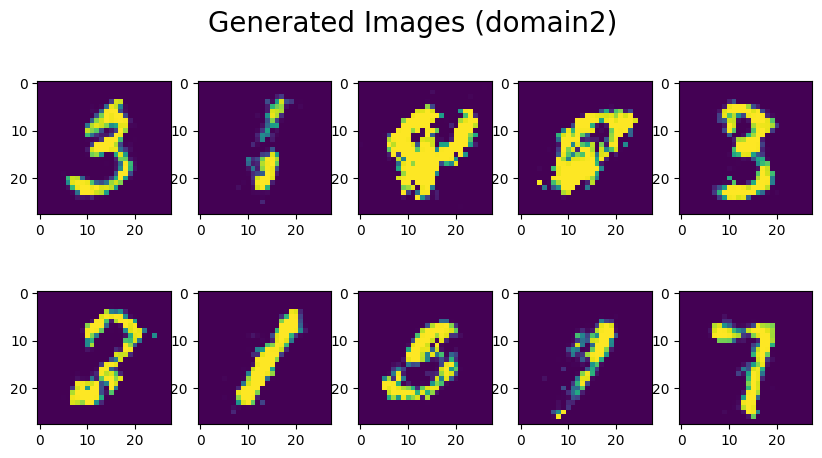

In [14]:
fig, ax = plt.subplots(2, 5, figsize = (10, 5))  
ax = ax.flatten()
for i in range(len(indices_plot)):
    ax[i].imshow(domain1[indices_plot[i]].reshape(28,28))
fig.suptitle("Original Images (domain1)", size=20)
plt.show()


fig, ax = plt.subplots(2, 5, figsize = (10, 5))  
ax = ax.flatten()
for i in range(len(indices_plot)):
    ax[i].imshow(x1g[indices_plot[i]].reshape(28, 28))
fig.suptitle("Generated Images (domain2)", size=20)
plt.show()

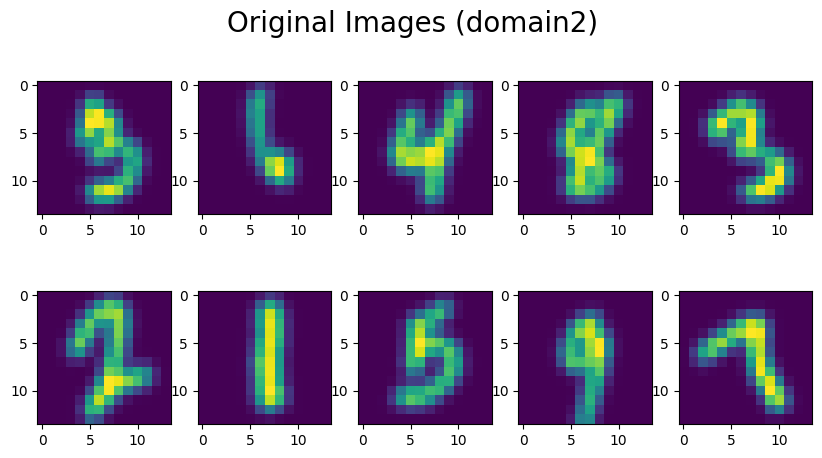

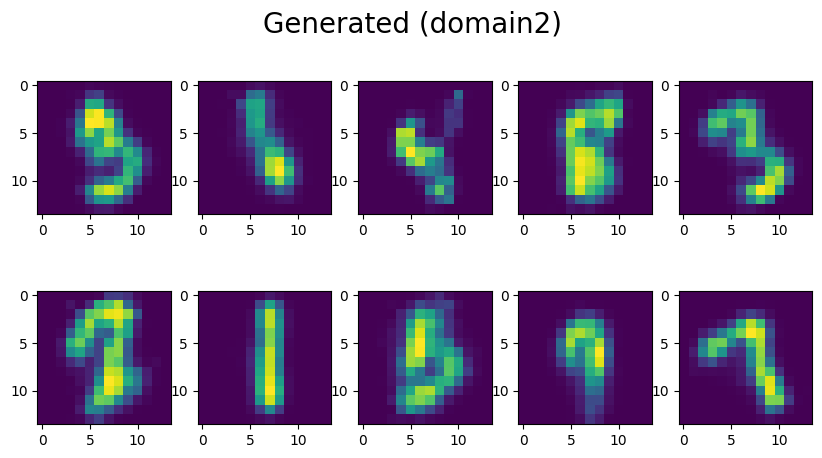

In [15]:
fig, ax = plt.subplots(2, 5, figsize = (10, 5))  
ax = ax.flatten()
for i in range(len(indices_plot)):
    ax[i].imshow(domain2[indices_plot[i]].reshape(14, 14))
fig.suptitle("Original Images (domain2)", size=20)
plt.show()


fig, ax = plt.subplots(2, 5, figsize = (10, 5))  
ax = ax.flatten()
for i in range(len(indices_plot)):
    ax[i].imshow(x2g[indices_plot[i]].reshape(14, 14))
fig.suptitle("Generated (domain2)", size=20)
plt.show()